In [4]:
import numpy as np
import matplotlib.pyplot as plt

#### Stock price simulator and Binomial tree with Delta's function

In [5]:
def stock_price_simulator(S0, mu, sigma, T, N, M):
    """
    Simulates stock price paths using Geometric Brownian Motion (GBM).
    
    Parameters:
    - S0: Initial stock price
    - mu: Drift term (expected return)
    - sigma: Volatility of the stock
    - T: Time to maturity
    - N: Number of time steps
    - M: Number of simulated paths
    
    Returns:
    - S: Simulated stock price paths (M x (N+1))
    """
    dt = T / N
    S = np.zeros((M, N + 1))
    S[:, 0] = S0
    for i in range(1, N + 1):
        S[:, i] = S[:, i - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1, M))
    return S

In [6]:
def build_binomial_tree_with_deltas(S0, K, T, r, sigma, N, exercise_dates, option_type="put"):
    """
    Builds a binomial tree for stock prices, option values, and deltas.
    """
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    stock_tree = np.zeros((N + 1, N + 1))
    option_tree = np.zeros((N + 1, N + 1))
    delta_tree = np.zeros((N, N))

    # Stock prices at maturity
    for i in range(N + 1):
        stock_tree[N, i] = S0 * (u ** (N - i)) * (d ** i)

    # Option values at maturity
    if option_type == "put":
        option_tree[N, :] = np.maximum(K - stock_tree[N, :], 0)
    else:
        option_tree[N, :] = np.maximum(stock_tree[N, :] - K, 0)

    # Backward induction for option values and deltas
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            stock_tree[i, j] = S0 * (u ** (i - j)) * (d ** j)
            continuation_value = np.exp(-r * dt) * (p * option_tree[i + 1, j] + (1 - p) * option_tree[i + 1, j + 1])

            if option_type == "put":
                exercise_value = max(K - stock_tree[i, j], 0)
            else:
                exercise_value = max(stock_tree[i, j] - K, 0)

            if (i * dt) in exercise_dates:
                option_tree[i, j] = max(continuation_value, exercise_value)
            else:
                option_tree[i, j] = continuation_value

            delta_tree[i, j] = (option_tree[i + 1, j] - option_tree[i + 1, j + 1]) / (stock_tree[i + 1, j] - stock_tree[i + 1, j + 1])

    return stock_tree, option_tree, delta_tree

#### Hedging experiment function

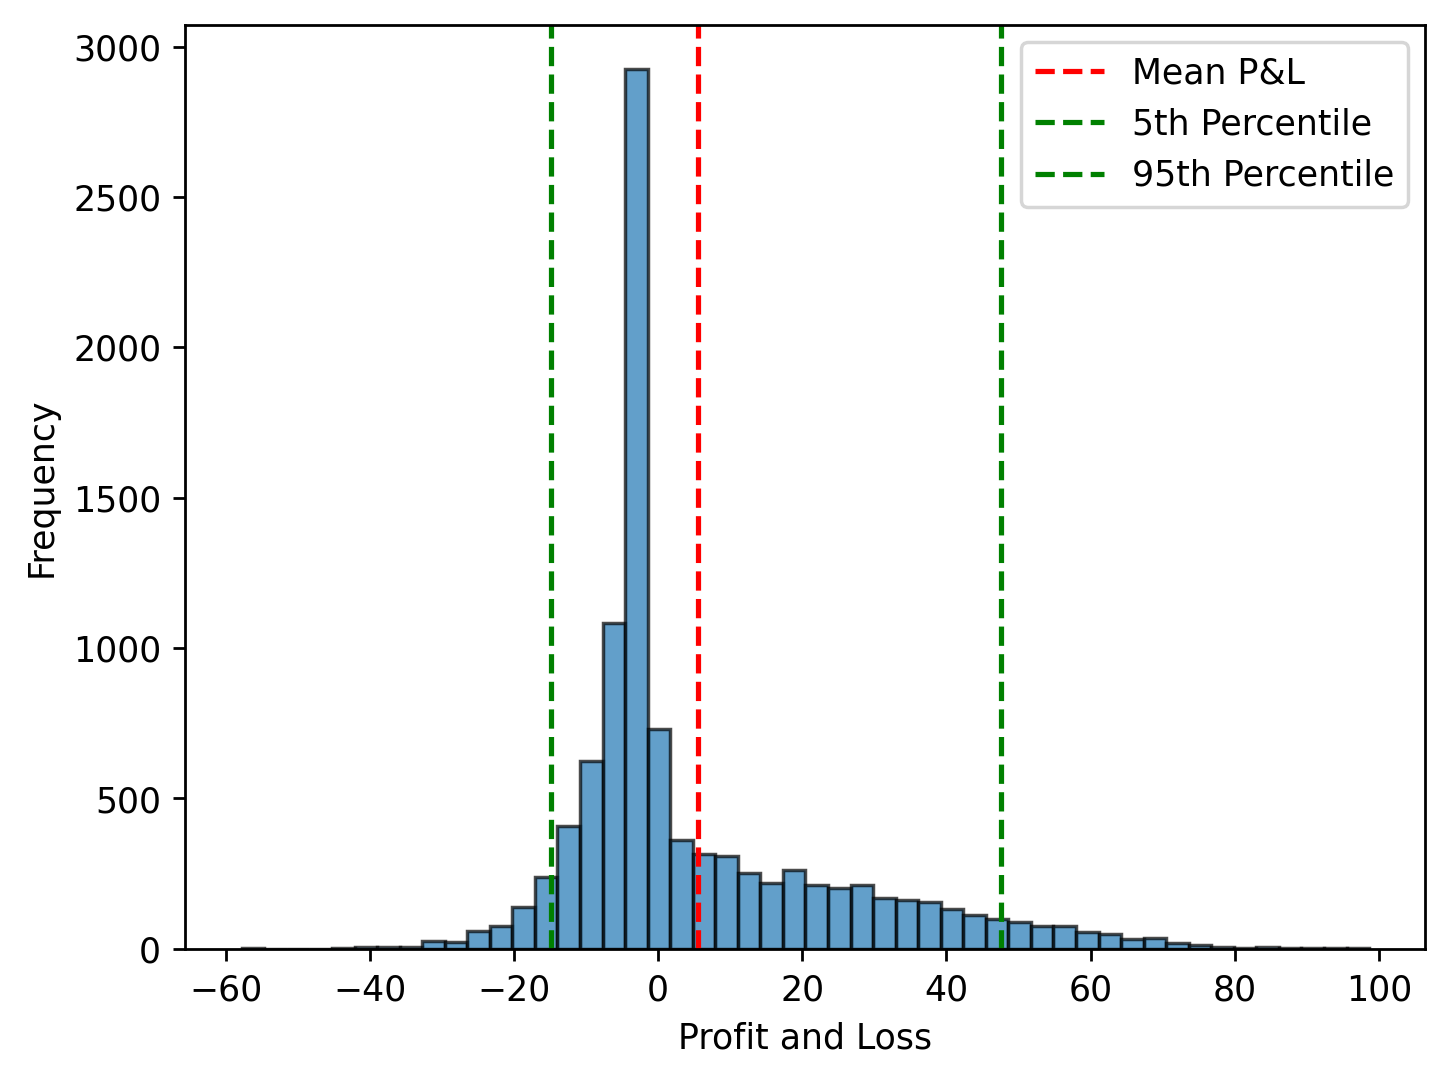

Mean P&L: 5.5751, 5th Percentile: -14.8498, 95th Percentile: 47.6125


array([-3.04455687, -2.65217521,  7.46763477, ..., -7.02796022,
       11.99125818, -3.4197821 ])

In [ ]:
def delta_hedging_experiment_bionmial_tree_gbm(S0, K, T, r, sigma, N, exercise_dates, option_type="put", num_simulations=10000):
    """
    Performs a delta hedging experiment using GBM-simulated stock prices and binomial tree deltas.
    """
    # Build the binomial tree for option valuation and deltas
    _, _, delta_tree = build_binomial_tree_with_deltas(S0, K, T, r, sigma, N, exercise_dates, option_type)

    # Simulate GBM stock price paths
    stock_paths = stock_price_simulator(S0, r, sigma, T, N, num_simulations)

    total_cost = []
    pay_received = []

    dt = T / N
    discount_factors = np.exp(-r * np.linspace(0, T, N + 1))

    for path in stock_paths:
        prev_delta = 0
        cost = 0

        for t in range(N):
            # Determine the number of down moves in the binomial tree approximation
            num_down_moves = sum(path[:t + 1] < S0)
            current_delta = delta_tree[t, num_down_moves]

            # Adjust portfolio
            delta_diff = current_delta - prev_delta
            cost -= delta_diff * path[t] * discount_factors[t]
            prev_delta = current_delta

        # Option payoff at maturity
        if option_type == "put":
            payoff = max(K - path[-1], 0)
        else:
            payoff = max(path[-1] - K, 0)

        # Final adjustment for delta position
        cost += prev_delta * path[-1] * discount_factors[-1]

        total_cost.append(cost)
        pay_received.append(payoff)

    # Calculate P&L
    final_PnL = np.array(pay_received) + np.array(total_cost)
    mean_PnL = np.mean(final_PnL)
    PnL_5 = np.percentile(final_PnL, 5)
    PnL_95 = np.percentile(final_PnL, 95)

    # Plotting
    fig, ax = plt.subplots(dpi=250)
    ax.hist(final_PnL, bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(x=mean_PnL, color="red", linestyle="--", label="Mean P&L")
    ax.axvline(x=PnL_5, color="green", linestyle="--", label="5th Percentile")
    ax.axvline(x=PnL_95, color="green", linestyle="--", label="95th Percentile")
    ax.set_xlabel("Profit and Loss")
    ax.set_ylabel("Frequency")
    ax.legend()
    plt.show()

    print(f"Mean P&L: {mean_PnL:.4f}, 5th Percentile: {PnL_5:.4f}, 95th Percentile: {PnL_95:.4f}")
    return final_PnL

# Parameters
S0 = 100
K = 100
T = 1
r = 0.05
sigma = 0.2
N = 50
exercise_dates = [0.25, 0.5, 0.75, 1.0]
option_type = "put"
num_simulations = 10000

# Run the experiment
delta_hedging_experiment_bionmial_tree_gbm(S0, K, T, r, sigma, N, exercise_dates, option_type, num_simulations)
